In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# survival
try:
    from lifelines import CoxPHFitter
    HAS_LIFELINES = True
except Exception:
    HAS_LIFELINES = False

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print('Has lifelines:', HAS_LIFELINES)


Has lifelines: False


### BANCO DE DADOS

---



In [ ]:
DATA_PATH = Path('falhas.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError('Coloque falhas.csv no mesmo diretório deste notebook e rode novamente.')

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())


Shape: (10000, 14)


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

### LIMPEZA INICIAL E IDENTIFICAÇÃO DO ALVO

---



In [ ]:
df.columns = [c.strip().replace(' ', '_').replace('[','').replace(']','') for c in df.columns]
print(df.columns.tolist())

['UDI', 'Product_ID', 'Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [ ]:
TARGET = 'Machine_failure' if 'Machine_failure' in df.columns else ('Machine failure' if 'Machine failure' in df.columns else df.columns[-1])
print('Alvo assumido:', TARGET)

Alvo assumido: Machine_failure


### REMOVENDO IDENTIFICADORES

---



In [ ]:
for col in ['UDI','Product_ID','Product_ID','Product ID','UDI ']:
    if col in df.columns:
        df = df.drop(columns=[col])

print('Shape após remoção de IDs:', df.shape)


Shape após remoção de IDs: (10000, 12)


### ESTATISTICAS DESCRITIVAS

---



In [ ]:
display(df.describe(include='all').T)

count unique  top  freq       mean         std  \
Type                     10000      3    L  6000        NaN         NaN   
Air_temperature_K      10000.0    NaN  NaN   NaN  300.00493    2.000259   
Process_temperature_K  10000.0    NaN  NaN   NaN  310.00556    1.483734   
Rotational_speed_rpm   10000.0    NaN  NaN   NaN  1538.7761  179.284096   
Torque_Nm              10000.0    NaN  NaN   NaN   39.98691    9.968934   
Tool_wear_min          10000.0    NaN  NaN   NaN    107.951   63.654147   
Machine_failure        10000.0    NaN  NaN   NaN     0.0339    0.180981   
TWF                    10000.0    NaN  NaN   NaN     0.0046    0.067671   
HDF                    10000.0    NaN  NaN   NaN     0.0115    0.106625   
PWF                    10000.0    NaN  NaN   NaN     0.0095    0.097009   
OSF                    10000.0    NaN  NaN   NaN     0.0098    0.098514   
RNF                    10000.0    NaN  NaN   NaN     0.0019     0.04355   

                          min     25%     50%     75%     max  
Type                      NaN     NaN     NaN     NaN     NaN  
Air_temperature_K       295.3   298.3   300.1   301.5   304.5  
Process_temperature_K   305.7   308.8   310.1   311.1   313.8  
Rotational_speed_rpm   1168.0  1423.0  1503.0  1612.0  2886.0  
Torque_Nm                 3.8    33.2    40.1    46.8    76.6  
Tool_wear_min             0.0    53.0   108.0   162.0   253.0  
Machine_failure           0.0     0.0     0.0     0.0     1.0  
TWF                       0.0     0.0     0.0     0.0     1.0  
HDF                       0.0     0.0     0.0     0.0     1.0  
PWF                       0.0     0.0     0.0     0.0     1.0  
OSF                       0.0     0.0     0.0     0.0     1.0  
RNF                       0.0     0.0     0.0     0.0     1.0

### NULOS

---



In [ ]:
print('\nNulos por coluna:')
print(df.isnull().sum())


Nulos por coluna:
Type                     0
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Tool_wear_min            0
Machine_failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64


### DISTRIBUIÇÃO DA VARIÁVEL ALVO

---



In [ ]:
print('\nContagem por classe:')
print(df[TARGET].value_counts())
print(df[TARGET].value_counts(normalize=True))


Contagem por classe:
Machine_failure
0    9661
1     339
Name: count, dtype: int64
Machine_failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


### VIZUALIZAÇÃO

---



In [ ]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c!=TARGET]
print('\nNuméricas detectadas:', num_cols)


Numéricas detectadas: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


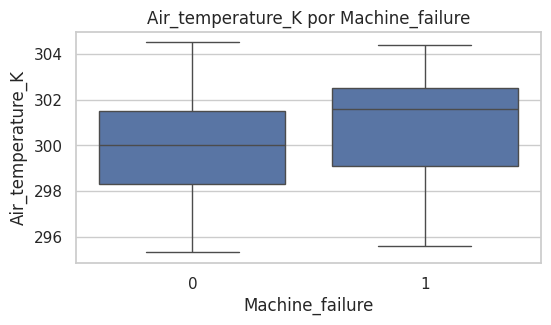

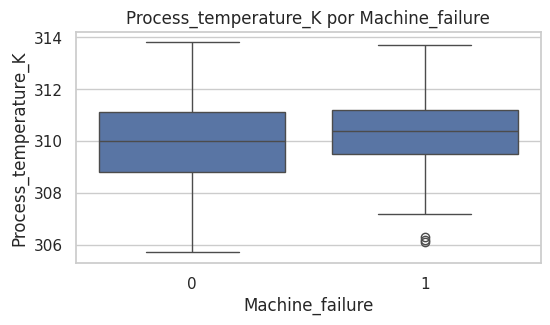

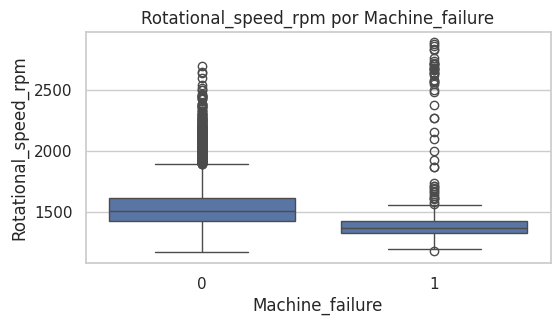

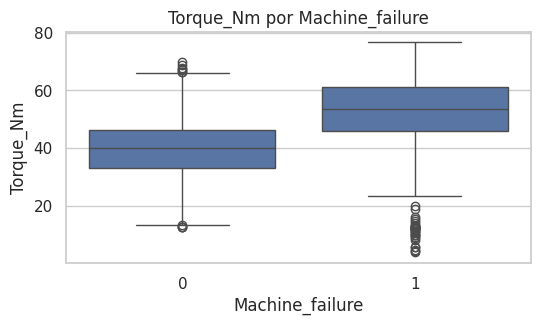

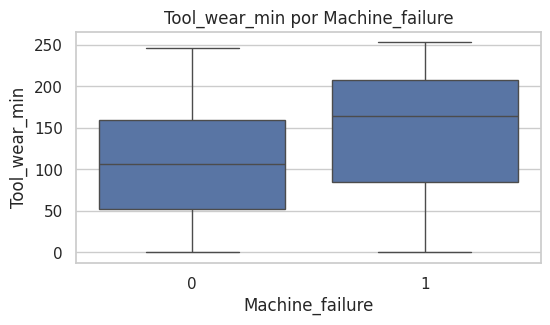

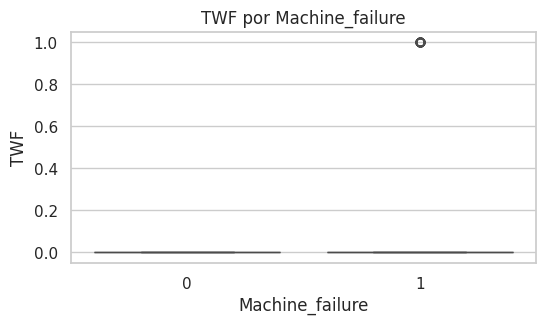

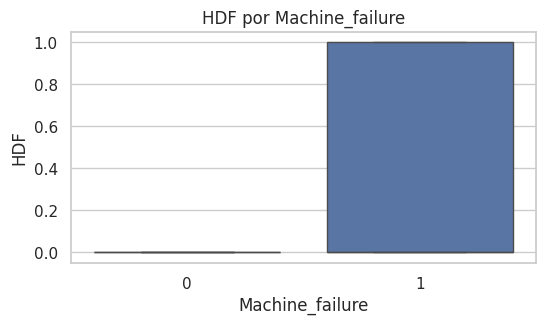

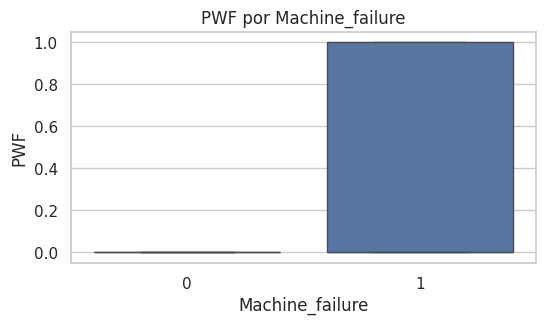

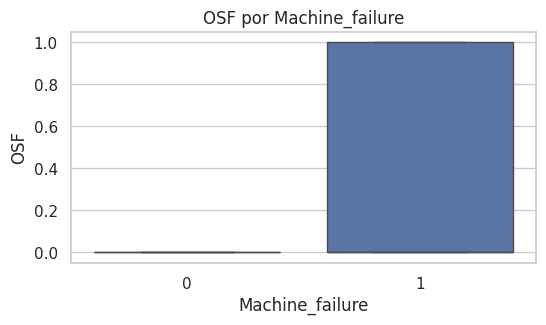

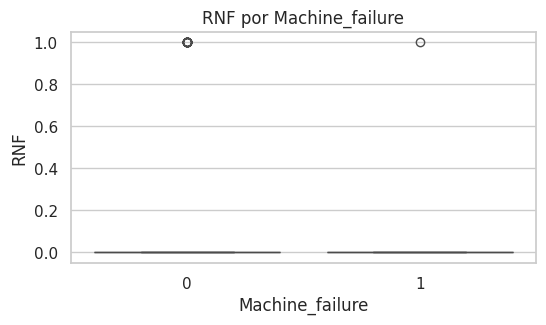

In [ ]:
import matplotlib.pyplot as plt
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=TARGET, y=col, data=df)
    plt.title(f'{col} por {TARGET}')
    plt.show()


### TESTES ESTATÍSTICOS ENTRE AS CLASSES E AS VARIÁVEIS NÚMERICAS

---



In [ ]:
# TEST T
from scipy import stats
results = []
for col in num_cols:
    grp0 = df[df[TARGET]==0][col].dropna()
    grp1 = df[df[TARGET]==1][col].dropna()
    if len(grp0)>10 and len(grp1)>10:
        t, p = stats.ttest_ind(grp0, grp1, equal_var=False)
        results.append((col, t, p))
results_df = pd.DataFrame(results, columns=['feature','t_stat','p_value']).sort_values('p_value')
display(results_df)


feature     t_stat       p_value
6                    HDF -13.172957  2.868296e-32
3              Torque_Nm -11.780813  3.635739e-27
8                    OSF -11.723651  7.255909e-27
7                    PWF -11.471633  5.960859e-26
4          Tool_wear_min  -9.264290  1.906011e-18
0      Air_temperature_K  -7.981703  1.950809e-14
5                    TWF  -7.284562  2.290720e-12
1  Process_temperature_K  -3.898388  1.151324e-04
2   Rotational_speed_rpm   2.086776  3.764748e-02
9                    RNF  -0.364380  7.157926e-01

*  Quanto maior F e menor P mais significativa é a diferença da média dessa variavel entre as classes 0 e 1.


*  Os resultados do teste mostram que as 8 primeiras variaveis têm p_value extremamente baixos mostrando que há diferenças fortes entre as classes são variaveis boas para predição.

*  A variavel Rotational_speed_rpm tem significância marginal p= 0.037 e
RNF não é significativa p=0.71, baixa utilidade para o modelo.


ENGENHARIA DE CARACTERISTICAS

---



In [ ]:
# CALCULAMOS A diferença de temperatura
air_cols = [c for c in df.columns if 'Air_temperature' in c or 'Air_temperature_K' in c or 'Air temperature' in c]
proc_cols = [c for c in df.columns if 'Process_temperature' in c or 'Process temperature' in c or 'Process_temperature_K' in c]
if air_cols and proc_cols:
    df['Temp_diff'] = df[proc_cols[0]] - df[air_cols[0]]
    print('Criada Temp_diff a partir de', proc_cols[0], 'e', air_cols[0])
else:
    print('Não detectadas colunas de temperatura com nomes padrões; verifique manualmente.')

Criada Temp_diff a partir de Process_temperature_K e Air_temperature_K


In [ ]:

if 'Torque_Nm' in df.columns and 'Rotational_speed_rpm' in df.columns:
    df['Torque_per_rpm'] = df['Torque_Nm'] / (df['Rotational_speed_rpm']+1e-9)
else:

    tcol = [c for c in df.columns if 'Torque' in c]
    rcol = [c for c in df.columns if 'Rotational' in c]
    if tcol and rcol:
        df['Torque_per_rpm'] = df[tcol[0]] / (df[rcol[0]]+1e-9)
        print('Criada Torque_per_rpm com', tcol[0], rcol[0])

display(df.head())


Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
0    M              298.1                  308.6                  1551   
1    L              298.2                  308.7                  1408   
2    L              298.1                  308.5                  1498   
3    L              298.2                  308.6                  1433   
4    L              298.2                  308.7                  1408   

   Torque_Nm  Tool_wear_min  Machine_failure  TWF  HDF  PWF  OSF  RNF  \
0       42.8              0                0    0    0    0    0    0   
1       46.3              3                0    0    0    0    0    0   
2       49.4              5                0    0    0    0    0    0   
3       39.5              7                0    0    0    0    0    0   
4       40.0              9                0    0    0    0    0    0   

   Temp_diff  Torque_per_rpm  
0       10.5        0.027595  
1       10.5        0.032884  
2       10.4        0.032977  
3       10.4        0.027565  
4       10.5        0.028409

### PREPARAÇÃO DOS DADOS PARA A REGRESSÃO

---



In [ ]:
# remover sublabels
for sub in ['TWF','HDF','PWF','OSF','RNF']:
    if sub in df.columns:
        df = df.drop(columns=[sub])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

In [ ]:
# identificar AS VARIAVEIS NUMERICAS E CATEGORICA
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print('num:', num_cols)
print('cat:', cat_cols)

num: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Temp_diff', 'Torque_per_rpm']
cat: ['Type']


### ESCALONAMENTO E TRANSFORMAÇÃO DE CATEGORICAS

---



In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

### SEPARANDO DADOS DE TREINO E TESTE

---



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/test shapes:', X_train.shape, X_test.shape)


Train/test shapes: (8000, 8) (2000, 8)


### MODELO 1 REGRESSÃO LOGISTICA REGULARIZADA (L1)

---



In [ ]:
pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000))
])

In [ ]:
# busca dos parametros
param_grid = {
    'clf__C':[0.01, 0.1, 1, 10, 100],

}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, scoring='average_precision', cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print('Melhor score (avg precision):', gs.best_score_)
print('Melhor param:', gs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhor score (avg precision): 0.4785951120826149
Melhor param: {'clf__C': 0.01}


In [ ]:
best_log = gs.best_estimator_
y_proba = best_log.predict_proba(X_test)[:,1]

### PREVISÕES MODELO 1

---



In [ ]:
y_pred_adj = (y_proba >= best_thresh).astype(int)

print('\nClassification report (Logistic L1 ajustado):')
print(classification_report(y_test, y_pred_adj, digits=4))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Average Precision (PR AUC):', average_precision_score(y_test, y_proba))



Classification report (Logistic L1 ajustado):
              precision    recall  f1-score   support

           0     0.9829    0.9808    0.9819      1932
           1     0.4861    0.5147    0.5000        68

    accuracy                         0.9650      2000
   macro avg     0.7345    0.7478    0.7409      2000
weighted avg     0.9660    0.9650    0.9655      2000

ROC AUC: 0.9231442577030813
Average Precision (PR AUC): 0.45629408848222563


O modelo consegue classificar  bem a classe majoritária 0 precisão e recall = 98%. Já para  classe minoritária 1 precisão = 48%, recall =51%  o modelo tem dificuldade em detectar falhas. Comportamento normal devido ao desbalanceamento do target muitos 0 e poucos 1 .



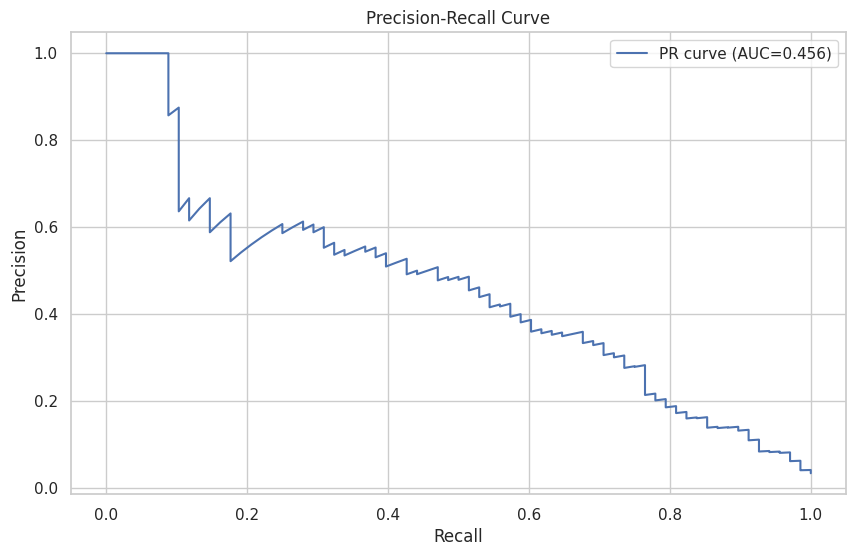

In [ ]:
pr_auc = average_precision_score(y_test, y_proba)
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.legend(); plt.show()

 PR AUC de 0.456 é moderado mostra que há bastante espaço para melhoria na identificação de falhas. precisão cai bastante para altos recalls.

### ODDS RATIOS

---



In [ ]:
def get_feature_names(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder': continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            cols_out = list(ohe.get_feature_names_out(cols))
            feature_names.extend(cols_out)
        else:
            feature_names.extend(cols)
    return feature_names

In [ ]:
fitted_preprocessor = best_log.named_steps['preproc']
feat_names = get_feature_names(fitted_preprocessor)
coef = best_log.named_steps['clf'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coef})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df = coef_df.sort_values('coef', ascending=False)
display(coef_df.head(20))

feature      coef  odds_ratio
6         Torque_per_rpm  1.975115    7.207451
2   Rotational_speed_rpm  1.330686    3.783639
4          Tool_wear_min  0.669314    1.952897
0      Air_temperature_K  0.047784    1.048945
1  Process_temperature_K  0.000000    1.000000
3              Torque_Nm  0.000000    1.000000
8                 Type_L  0.000000    1.000000
7                 Type_H  0.000000    1.000000
9                 Type_M -0.021758    0.978477
5              Temp_diff -0.591089    0.553724

### VISUAIZANDO E SALVADO AS PREVISÕES PARA O MODELO 1

---



In [ ]:
pred_df = X_test.copy()
pred_df['Real'] = y_test.values
pred_df['Predito'] = y_pred_adj
pred_df['Prob_Falha'] = y_proba
out_path = Path('previsoes_falhas.csv')
pred_df.to_csv(out_path, index=False)
print('Previsões salvas em', out_path)
display(pred_df.head())

Previsões salvas em previsoes_falhas.csv


Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
2997    L              300.5                  309.8                  1345   
4871    L              303.7                  312.4                  1513   
3858    L              302.5                  311.4                  1559   
951     H              295.6                  306.3                  1509   
6463    H              300.5                  310.0                  1358   

      Torque_Nm  Tool_wear_min  Temp_diff  Torque_per_rpm  Real  Predito  \
2997       62.7            153        9.3        0.046617     0        1   
4871       40.1            135        8.7        0.026504     0        0   
3858       37.6            209        8.9        0.024118     0        0   
951        35.8             60       10.7        0.023724     0        0   
6463       60.4            102        9.5        0.044477     0        1   

      Prob_Falha  
2997    0.938798  
4871    0.434264  
3858    0.543648  
951     0.044053  
6463    0.844923

### escolha do threshold que maximiza F1

---



In [ ]:
#
f1_scores = 2*(precision*recall)/(precision+recall+1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
print('Best threshold (F1):', best_thresh)


Best threshold (F1): 0.8275828899240043


### Aplicando o melhor threshold

---



In [ ]:
y_pred_best = (y_proba >= best_thresh).astype(int)

print("\nClassification report com threshold ajustado:")
print(classification_report(y_test, y_pred_best, digits=4))


Classification report com threshold ajustado:
              precision    recall  f1-score   support

           0     0.9829    0.9808    0.9819      1932
           1     0.4861    0.5147    0.5000        68

    accuracy                         0.9650      2000
   macro avg     0.7345    0.7478    0.7409      2000
weighted avg     0.9660    0.9650    0.9655      2000



### METRICAS ADICIONAIS

---



In [ ]:
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC AUC (mesmo): {roc_auc:.3f}")
print(f"PR AUC (mesmo): {pr_auc:.3f}")

ROC AUC (mesmo): 0.923
PR AUC (mesmo): 0.456


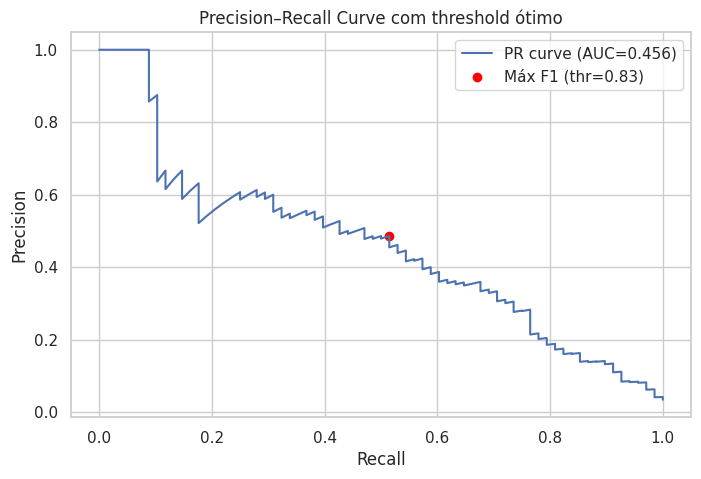

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f})')
plt.scatter(recall[best_idx], precision[best_idx],
            marker='o', color='red', label=f'Máx F1 (thr={best_thresh:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve com threshold ótimo')
plt.legend()
plt.show()

### RESULTADOS

---



MODELO 1 : threshold=0.5

Muita detecção (recall alto), mas com enorme número de falsos positivos (precision baixíssima).

MODELO 2 :  threshold=0.83

modelo consegue um equilíbrio muito melhor entre precision e recall.
F1-score quase dobrou o modelo ficou muito mais útil para a classe minoritária.

### salvando o banco de dados de previsão com o limiar de decisão de 0,83.

---



In [ ]:
from pathlib import Path
import pandas as pd


pred_df = X_test.copy()
pred_df['Real'] = y_test.values
pred_df['Predito'] = y_pred_adj
pred_df['Prob_Falha'] = y_proba


out_path = Path('previsoes_falhas_threshold_ajustado.csv')
pred_df.to_csv(out_path, index=False)

print('Previsões salvas em', out_path)
display(pred_df.head())

Previsões salvas em previsoes_falhas_threshold_ajustado.csv


Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
2997    L              300.5                  309.8                  1345   
4871    L              303.7                  312.4                  1513   
3858    L              302.5                  311.4                  1559   
951     H              295.6                  306.3                  1509   
6463    H              300.5                  310.0                  1358   

      Torque_Nm  Tool_wear_min  Temp_diff  Torque_per_rpm  Real  Predito  \
2997       62.7            153        9.3        0.046617     0        1   
4871       40.1            135        8.7        0.026504     0        0   
3858       37.6            209        8.9        0.024118     0        0   
951        35.8             60       10.7        0.023724     0        0   
6463       60.4            102        9.5        0.044477     0        1   

      Prob_Falha  
2997    0.938798  
4871    0.434264  
3858    0.543648  
951     0.044053  
6463    0.844923



---
Com o threshold padrão de 0,5 a regressão logística apresentava alta sensibilidade para falhas, mas com muitos falsos positivos. Ajustando o limiar de decisão para 0,83 (valor que maximizou o F1-score), obtivemos um modelo mais equilibrado: a precisão para a classe de falhas aumentou de 0,15 para 0,49 e o F1-score dobrou de 0,26 para 0,50, mantendo alta performance para a classe normal (não falha).  Essa abordagem mostrou que o ajuste do limiar é essencial para melhorar o desempenho do modelo em dados desbalanceados sem recorrer a oversampling adicional como SMOTE.
